Forcasting in Engineering und Management

In [231]:
# ----------------------------------------
# Forecasting in Engineering & Management
# Main Notebook: FoEM_Projekt.ipynb
# Cleaned for S&P 500 only with TRAIN/TEST support
# ----------------------------------------

# Core packages
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

# Statistical tools
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.tseries.offsets import BDay
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from prophet import Prophet

# ML/DL Tools
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, SimpleRNN, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler

# Evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Utilities
import os
import warnings
warnings.filterwarnings("ignore")
import logging
from datetime import timedelta

# Logging setup
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [232]:
# ----------------------------------------
# Step 0: CONFIGURATION SECTION
# ----------------------------------------


# ⏳ Data History
HISTORY_YEARS = 26             # How many years of historical data to use

# 🔮 Forecasting
FORECAST_DAYS = 90            # How many business days to forecast

# ⚙️ Model Split
TRAIN_TEST_SPLIT = 0.8        # Train/Test ratio

# 💹 Target Symbol
TICKER = "^GSPC"              # S&P 500 Index (via yfinance)

# 🧠 Reproducibility
SEED = 42

In [233]:
# ----------------------------------------
# Step 1: LOAD & CLEAN TIME SERIES DATA
# ----------------------------------------

# Define date range
end_date = dt.datetime.today()
start_date = end_date - timedelta(days=HISTORY_YEARS * 365)

# Fetch S&P 500 data
logging.info(f"📥 Downloading S&P 500 data from {start_date.date()} to {end_date.date()}...")
sp500 = yf.download(TICKER, start=start_date, end=end_date, progress=False, auto_adjust=False)

# Check if MultiIndex is present (older yfinance versions)
print("\n📋 Raw Columns from yfinance:", sp500.columns.tolist())
if isinstance(sp500.columns, pd.MultiIndex):
    sp500.columns = [col[0] for col in sp500.columns]

# Select relevant columns
expected_cols = ['Close', 'Open', 'High', 'Low', 'Volume']
sp500 = sp500[[col for col in expected_cols if col in sp500.columns]].copy()

# Clean index and fill missing values
sp500.index = pd.to_datetime(sp500.index)
sp500 = sp500.asfreq('B')
sp500 = sp500.ffill()

# Data summary
print(f"\n✅ Dataset Shape: {sp500.shape}")
print(f"🗓️  Time Range : {sp500.index.min().date()} → {sp500.index.max().date()}")
print("🔎 Columns     :", ', '.join(map(str, sp500.columns)))
print("\n🧼 Missing Values:")
print(sp500.isna().sum())
print("\nℹ️ Use HISTORY_YEARS in config to adjust data range.")


2025-06-14 18:38:17,371 - INFO - 📥 Downloading S&P 500 data from 1999-06-21 to 2025-06-14...



📋 Raw Columns from yfinance: [('Adj Close', '^GSPC'), ('Close', '^GSPC'), ('High', '^GSPC'), ('Low', '^GSPC'), ('Open', '^GSPC'), ('Volume', '^GSPC')]

✅ Dataset Shape: (6780, 5)
🗓️  Time Range : 1999-06-21 → 2025-06-13
🔎 Columns     : Close, Open, High, Low, Volume

🧼 Missing Values:
Close     0
Open      0
High      0
Low       0
Volume    0
dtype: int64

ℹ️ Use HISTORY_YEARS in config to adjust data range.


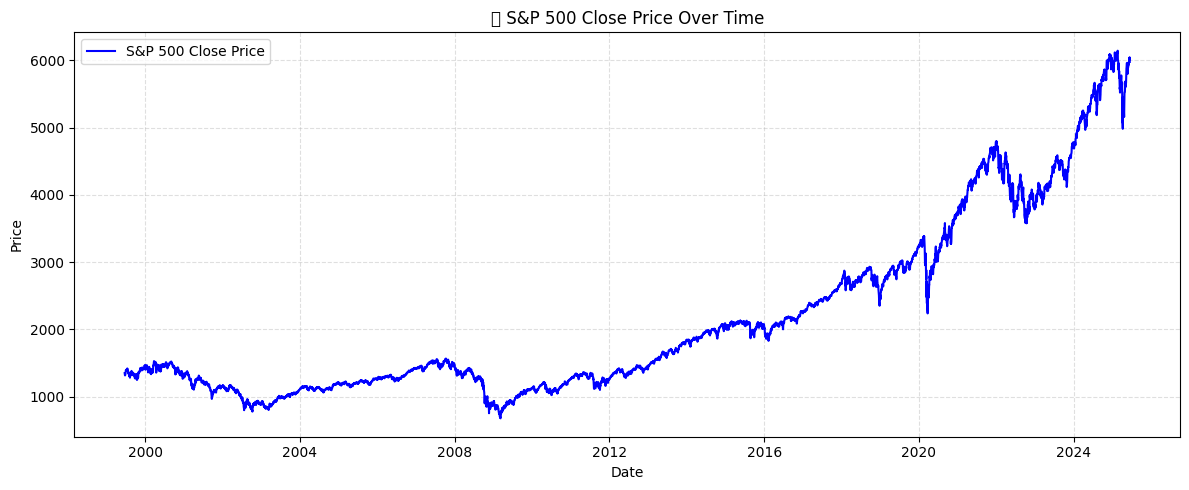

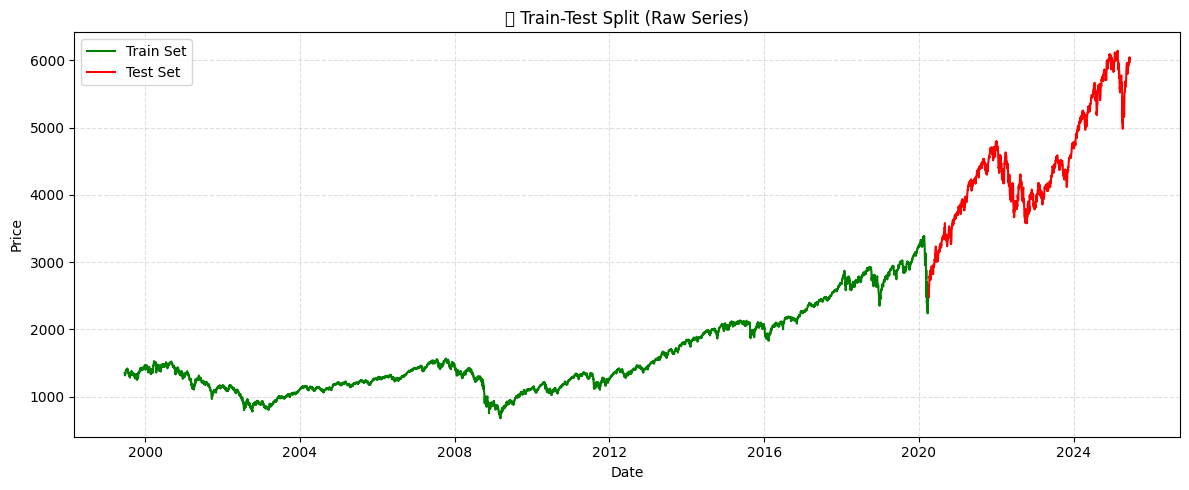

🧾 Training samples: 5424
🧾 Testing samples : 1356
📆 Train Range     : 1999-06-21 → 2020-04-02
📆 Test Range      : 2020-04-03 → 2025-06-13


In [234]:
# ----------------------------------------
# Step 2: VISUALIZE & SPLIT TIME SERIES (Raw)
# ----------------------------------------

# ✅ Use 'Close' price as the main target
ts_full = sp500['Close'].copy()
ts_raw = ts_full.copy()  # ✅ Keep a clean version for global use (used later for decomposition, Prophet etc.)

# Plot full raw series
plt.figure(figsize=(12, 5))
plt.plot(ts_full, label='S&P 500 Close Price', color='blue')
plt.title("📈 S&P 500 Close Price Over Time")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

# 📦 Split 80/20 for forecasting
split_ratio = 0.8
split_index = int(len(ts_full) * split_ratio)
ts_train_raw = ts_full[:split_index]
ts_test_raw  = ts_full[split_index:]

# 📊 Visualize split
plt.figure(figsize=(12, 5))
plt.plot(ts_train_raw, label='Train Set', color='green')
plt.plot(ts_test_raw, label='Test Set', color='red')
plt.title("🧪 Train-Test Split (Raw Series)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

# 🧾 Summary
print(f"🧾 Training samples: {len(ts_train_raw)}")
print(f"🧾 Testing samples : {len(ts_test_raw)}")
print(f"📆 Train Range     : {ts_train_raw.index.min().date()} → {ts_train_raw.index.max().date()}")
print(f"📆 Test Range      : {ts_test_raw.index.min().date()} → {ts_test_raw.index.max().date()}")


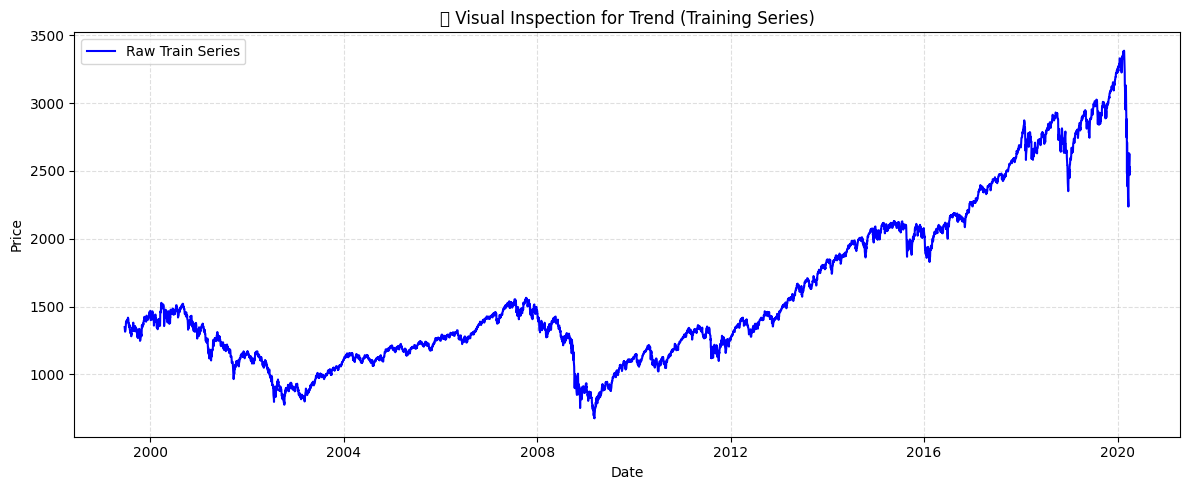

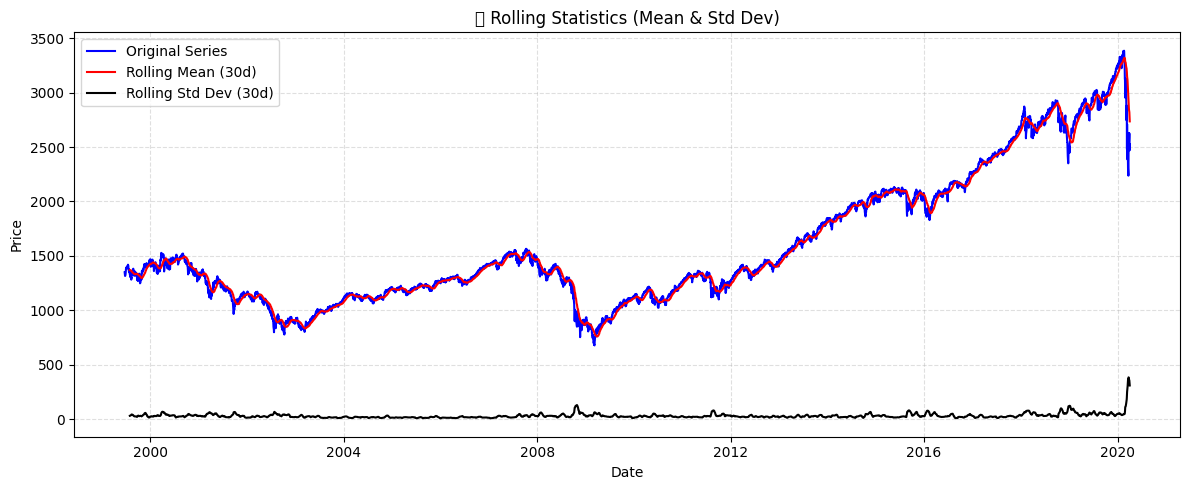

📊 Augmented Dickey-Fuller Test Results
ADF Statistic : -0.6920
p-value       : 0.8488
Critical Values:
   1% : -3.4316
   5% : -2.8621
   10% : -2.5671
❌ Likely NON-STATIONARY (Fail to reject H₀)


In [235]:
# ----------------------------------------
# Step 3: Stationarity Check (Training Set)
# ----------------------------------------


# 1. Visual Trend Inspection
plt.figure(figsize=(12, 5))
plt.plot(ts_train_raw, label='Raw Train Series', color='blue')
plt.title("🔍 Visual Inspection for Trend (Training Series)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

# 2. Rolling Mean and Std Dev (30-day window)
rolmean = ts_train_raw.rolling(window=30).mean()
rolstd = ts_train_raw.rolling(window=30).std()

plt.figure(figsize=(12, 5))
plt.plot(ts_train_raw, label='Original Series', color='blue')
plt.plot(rolmean, label='Rolling Mean (30d)', color='red')
plt.plot(rolstd, label='Rolling Std Dev (30d)', color='black')
plt.title("📉 Rolling Statistics (Mean & Std Dev)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

# 3. Augmented Dickey-Fuller Test
adf_result = adfuller(ts_train_raw.dropna())
adf_stat, p_value, _, _, critical_values, _ = adf_result

print("📊 Augmented Dickey-Fuller Test Results")
print(f"ADF Statistic : {adf_stat:.4f}")
print(f"p-value       : {p_value:.4f}")
print("Critical Values:")
for key, value in critical_values.items():
    print(f"   {key} : {value:.4f}")

# 4. Interpretation
if p_value <= 0.05:
    print("✅ Likely STATIONARY (Reject H₀)")
else:
    print("❌ Likely NON-STATIONARY (Fail to reject H₀)")


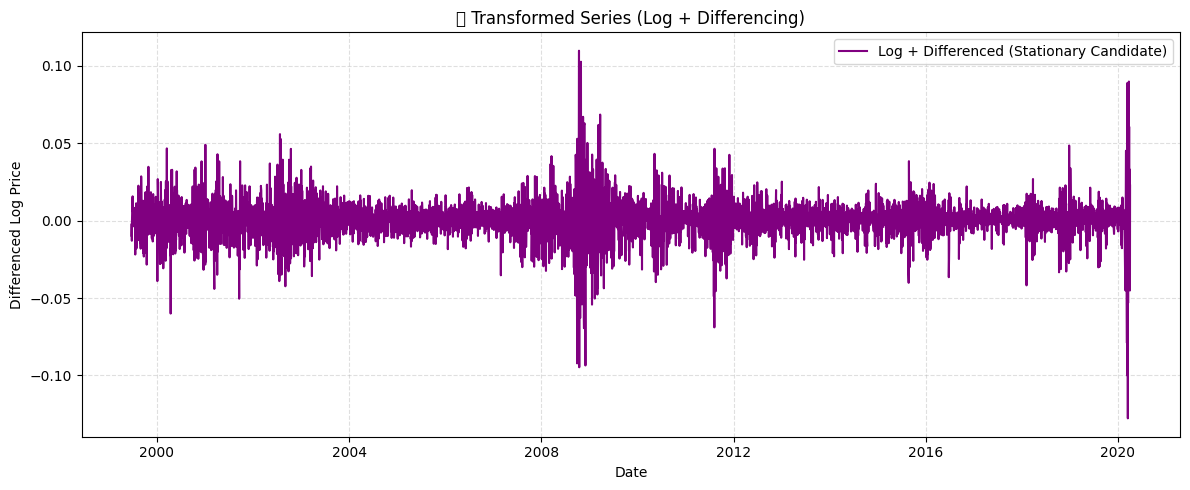

📊 ADF Test on Transformed Series
ADF Statistic : -17.0895
p-value       : 0.0000
Critical Values:
   1% : -3.4316
   5% : -2.8621
   10% : -2.5671
✅ Stationarity Achieved! Use this for ARIMA/SARIMA


In [236]:
# ----------------------------------------
# Step 4: Make the Series Stationary (Train)
# ----------------------------------------

# 1. Log transformation (to stabilize variance)
ts_train_log = np.log(ts_train_raw)

# 2. First differencing (remove trend)
ts_stationary_train = ts_train_log.diff().dropna()

# Plot the result
plt.figure(figsize=(12, 5))
plt.plot(ts_stationary_train, label='Log + Differenced (Stationary Candidate)', color='purple')
plt.title("📉 Transformed Series (Log + Differencing)")
plt.xlabel("Date")
plt.ylabel("Differenced Log Price")
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

# Re-run ADF Test on transformed series
adf_result_trans = adfuller(ts_stationary_train)
adf_stat, p_value, _, _, critical_values, _ = adf_result_trans

print("📊 ADF Test on Transformed Series")
print(f"ADF Statistic : {adf_stat:.4f}")
print(f"p-value       : {p_value:.4f}")
print("Critical Values:")
for key, value in critical_values.items():
    print(f"   {key} : {value:.4f}")

if p_value <= 0.05:
    print("✅ Stationarity Achieved! Use this for ARIMA/SARIMA")
else:
    print("❌ Still Non-Stationary. Consider higher-order differencing.")


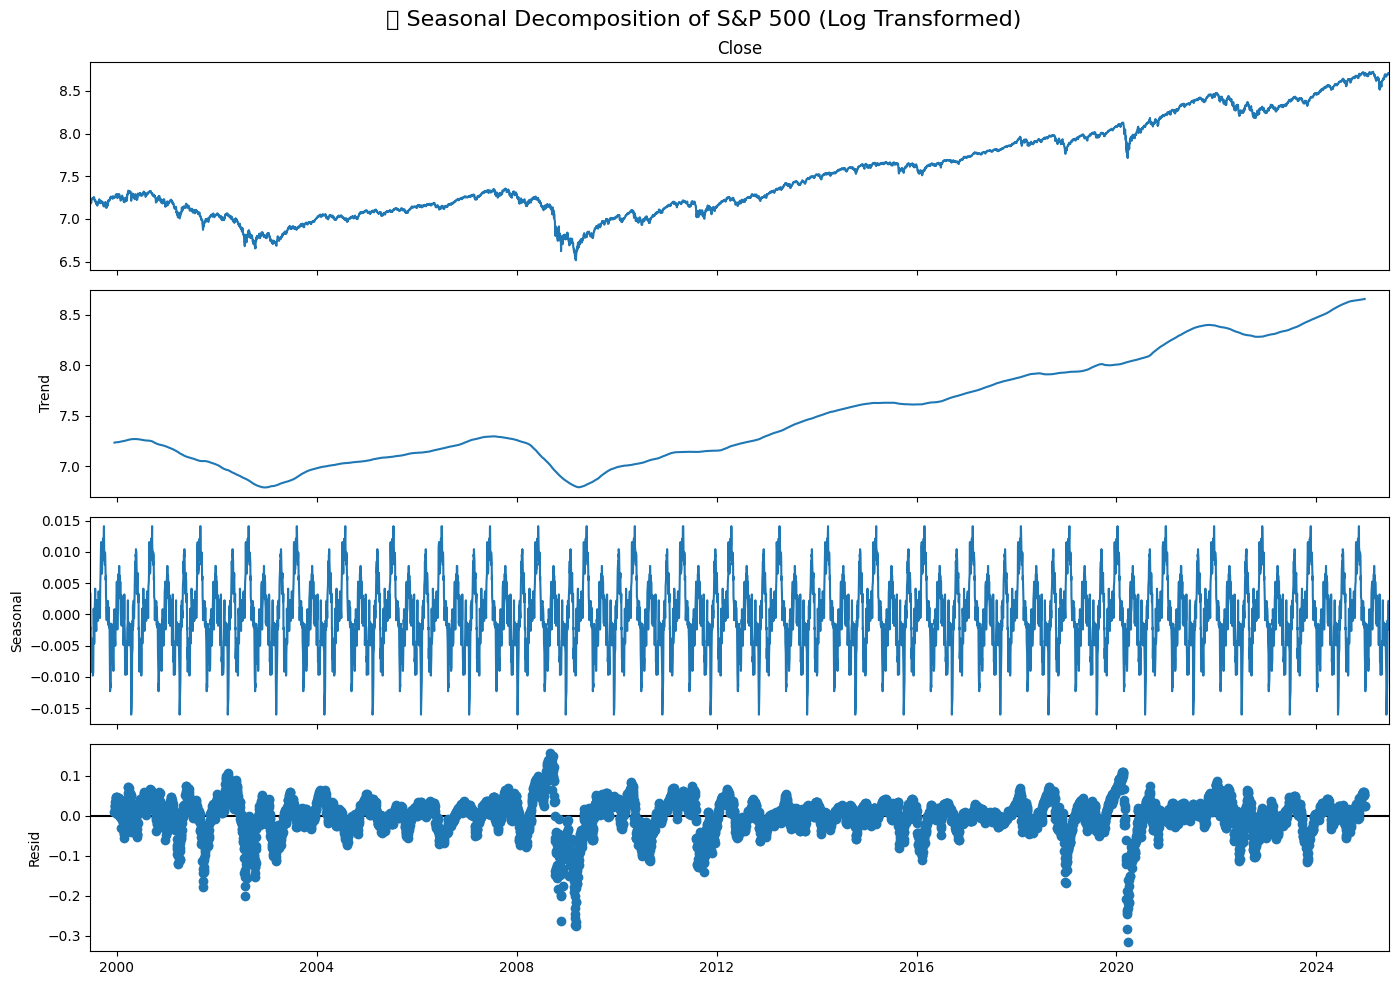


📌 Component Overview:
• Trend Sample (last 5):
Date
2024-12-13    8.655275
2024-12-16    8.655657
2024-12-17    8.656054
2024-12-18    8.656452
2024-12-19    8.656823
Freq: B, Name: trend, dtype: float64

• Seasonal Sample (unique pattern over a year):
Date
2024-06-27    0.000558
2024-06-28   -0.000614
2024-07-01    0.001711
2024-07-02    0.003078
2024-07-03    0.004497
Freq: B, Name: seasonal, dtype: float64

• Residual Sample (last 5):
Date
2024-12-13    0.052984
2024-12-16    0.058249
2024-12-17    0.053083
2024-12-18    0.023531
2024-12-19    0.024809
Freq: B, Name: resid, dtype: float64


In [237]:
# ----------------------------------------
# Step 5: Seasonal Decomposition
# ----------------------------------------

# Apply log transform to full original series (not differenced)
ts_log_full = np.log(ts_raw)

# Decompose the log-transformed series using additive model
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log_full, model='additive', period=252)  # ~1 trading year

# Plot decomposition
fig = decomposition.plot()
fig.set_size_inches(14, 10)
fig.suptitle("🔍 Seasonal Decomposition of S&P 500 (Log Transformed)", fontsize=16)
plt.tight_layout()
plt.show()

# Optionally extract the components
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Print summary values for interpretation
print("\n📌 Component Overview:")
print(f"• Trend Sample (last 5):\n{trend.dropna().tail()}")
print(f"\n• Seasonal Sample (unique pattern over a year):\n{seasonal[-252:].head()}")
print(f"\n• Residual Sample (last 5):\n{residual.dropna().tail()}")


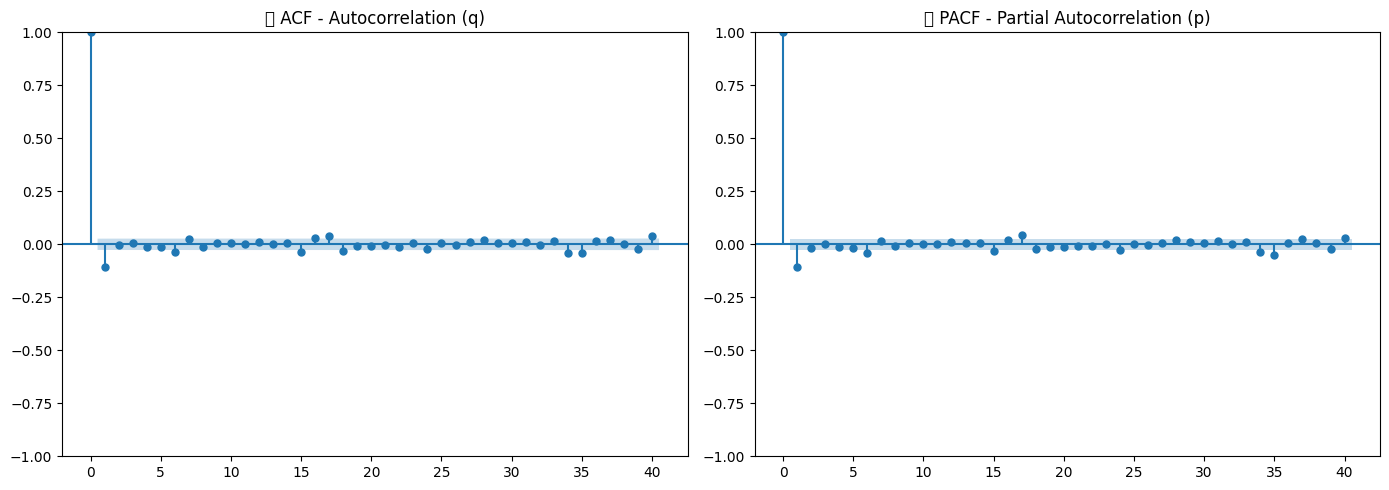


📌 Interpretation Hint:
• Use ACF to estimate MA(q): how many lags have significant correlation.
• Use PACF to estimate AR(p): look for the lag where partial correlation sharply drops.
• A sudden drop after lag 1 or 2 often suggests a good cutoff.


In [238]:
# ----------------------------------------
# Step 6: ACF & PACF (for ARIMA Tuning)
# ----------------------------------------

# Plot ACF and PACF using stationarized training series
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

plot_acf(ts_stationary_train.dropna(), ax=axes[0], lags=40)
axes[0].set_title("📉 ACF - Autocorrelation (q)")

plot_pacf(ts_stationary_train.dropna(), ax=axes[1], lags=40, method='ywm')
axes[1].set_title("📈 PACF - Partial Autocorrelation (p)")

plt.tight_layout()
plt.show()

# 🔍 Interpretation Hint:
print("\n📌 Interpretation Hint:")
print("• Use ACF to estimate MA(q): how many lags have significant correlation.")
print("• Use PACF to estimate AR(p): look for the lag where partial correlation sharply drops.")
print("• A sudden drop after lag 1 or 2 often suggests a good cutoff.")


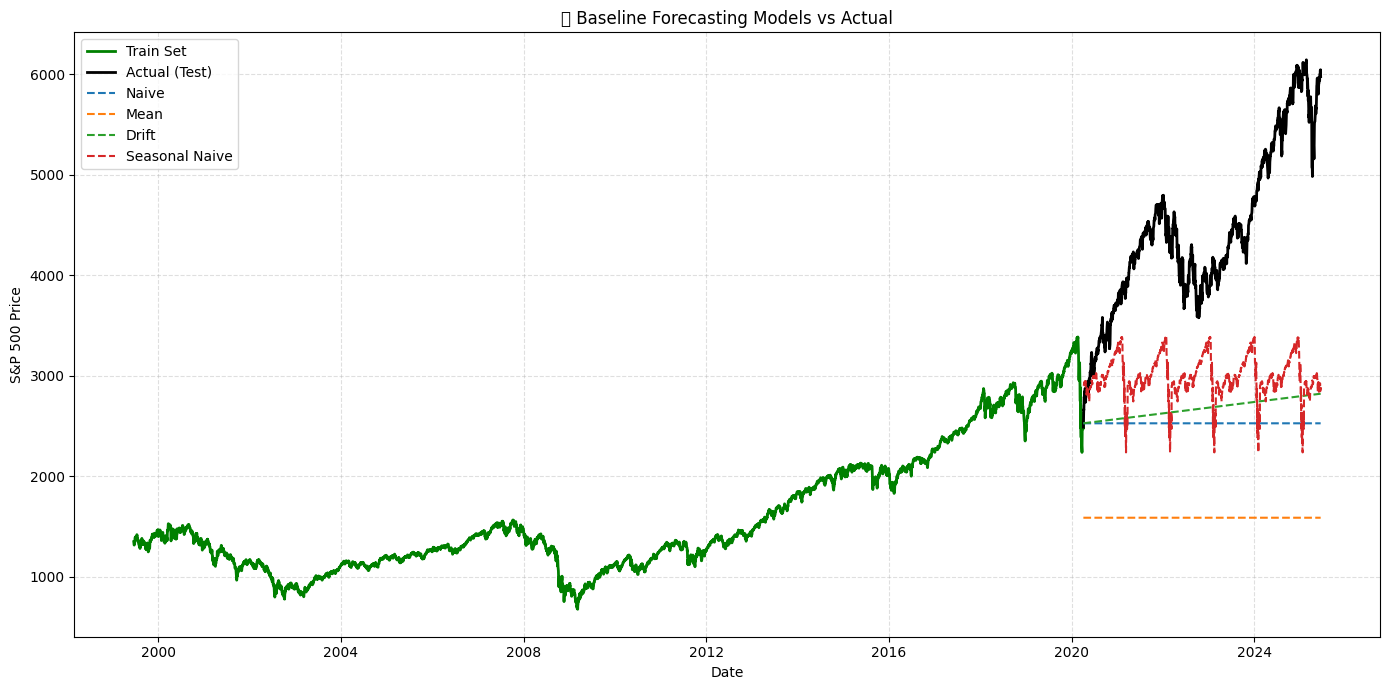


📌 Use these as benchmarks. If your ARIMA/LSTM/Prophet can't beat these, they may be overkill or under-tuned.


In [239]:
# ----------------------------------------
# Step 7: Basic Forecasting Models (Benchmarks)
# ----------------------------------------

# Define forecast horizon (length of test set)
n_test = len(ts_test_raw)

# Index for predictions
forecast_index = ts_test_raw.index

# 1️⃣ Naive Forecast: last observed value
naive_forecast = pd.Series(ts_train_raw.iloc[-1], index=forecast_index)

# 2️⃣ Mean Forecast: average of training set
mean_forecast = pd.Series(ts_train_raw.mean(), index=forecast_index)

# 3️⃣ Drift Forecast: linear increase from start to end of training
drift_slope = (ts_train_raw.iloc[-1] - ts_train_raw.iloc[0]) / (len(ts_train_raw) - 1)
drift_forecast = pd.Series([ts_train_raw.iloc[-1] + i * drift_slope for i in range(1, n_test + 1)], index=forecast_index)

# 4️⃣ Seasonal Naive: reuse values from previous season (wrap if needed)
seasonal_period = 252

if len(ts_train_raw) >= seasonal_period:
    seasonal_values = ts_train_raw[-seasonal_period:].values
    repeats = int(np.ceil(n_test / seasonal_period))
    repeated = np.tile(seasonal_values, repeats)[:n_test]
    seasonal_naive_forecast = pd.Series(repeated, index=forecast_index)
else:
    seasonal_naive_forecast = pd.Series(np.nan, index=forecast_index)


# ----------------------------------------
# Plot all basic forecasts with actual
# ----------------------------------------

plt.figure(figsize=(14, 7))
plt.plot(ts_train_raw, label='Train Set', color='green', linewidth=2)
plt.plot(ts_test_raw, label='Actual (Test)', linewidth=2, color='black')
plt.plot(naive_forecast, label='Naive', linestyle='--')
plt.plot(mean_forecast, label='Mean', linestyle='--')
plt.plot(drift_forecast, label='Drift', linestyle='--')
plt.plot(seasonal_naive_forecast, label='Seasonal Naive', linestyle='--')

plt.title("🧪 Baseline Forecasting Models vs Actual")
plt.xlabel("Date")
plt.ylabel("S&P 500 Price")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

# 🧾 Hint:
print("\n📌 Use these as benchmarks. If your ARIMA/LSTM/Prophet can't beat these, they may be overkill or under-tuned.")


📊 Baseline Model Evaluation on Test Set:


,MAE,RMSE,MAPE
Mean,2866.07,2978.99,63.14
Naive,1926.51,2090.76,41.32
Seasonal Naive,1463.60,1682.20,30.64
Drift,1779.14,1926.93,38.21


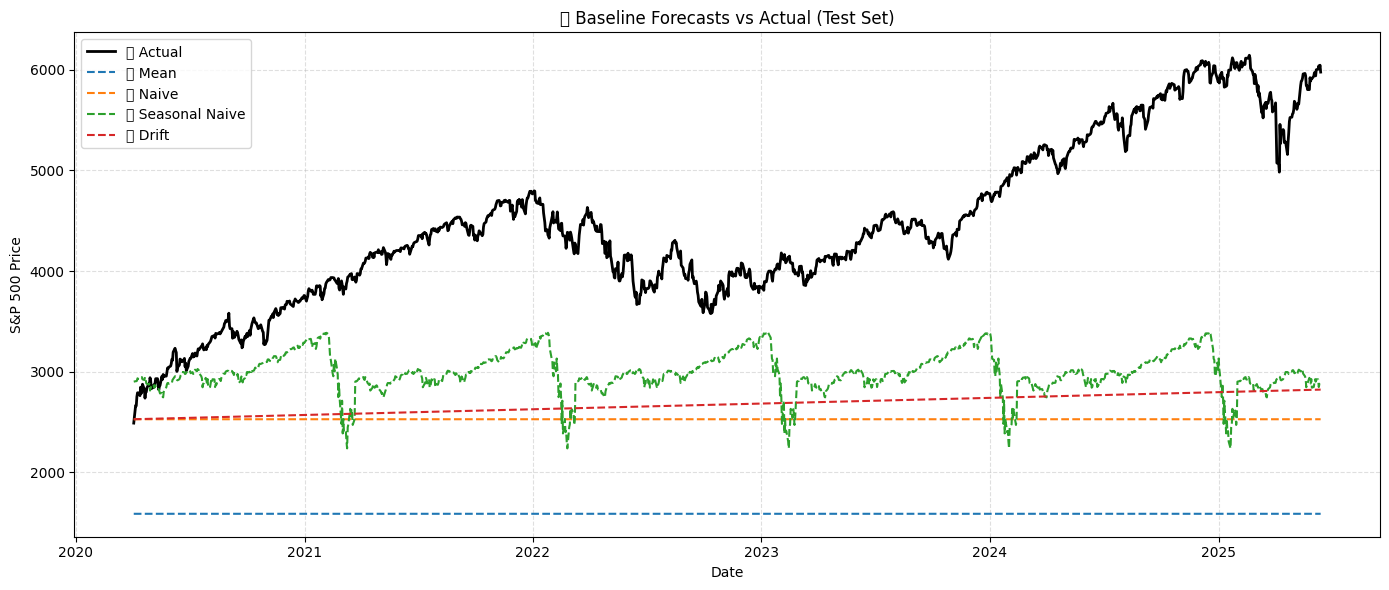

In [240]:
# ----------------------------------------
# Step 8: Evaluation of Basic Forecasting Models
# ----------------------------------------

# Define evaluation function
def evaluate_forecast(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return {"MAE": mae, "RMSE": rmse, "MAPE": mape}

# Evaluate each model
baseline_metrics = {
    "Mean": evaluate_forecast(ts_test_raw, mean_forecast),
    "Naive": evaluate_forecast(ts_test_raw, naive_forecast),
    "Seasonal Naive": evaluate_forecast(ts_test_raw, seasonal_naive_forecast),
    "Drift": evaluate_forecast(ts_test_raw, drift_forecast),
}

# Convert to DataFrame
baseline_df = pd.DataFrame(baseline_metrics).T.round(2)

# Display results
print("📊 Baseline Model Evaluation on Test Set:")
display(baseline_df)

# 📈 Plot actual vs baseline forecasts
plt.figure(figsize=(14, 6))
plt.plot(ts_test_raw, label="📌 Actual", color="black", linewidth=2)
plt.plot(mean_forecast, label="🔵 Mean", linestyle="--")
plt.plot(naive_forecast, label="🟢 Naive", linestyle="--")
plt.plot(seasonal_naive_forecast, label="🟣 Seasonal Naive", linestyle="--")
plt.plot(drift_forecast, label="🔶 Drift", linestyle="--")
plt.title("📉 Baseline Forecasts vs Actual (Test Set)")
plt.xlabel("Date")
plt.ylabel("S&P 500 Price")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


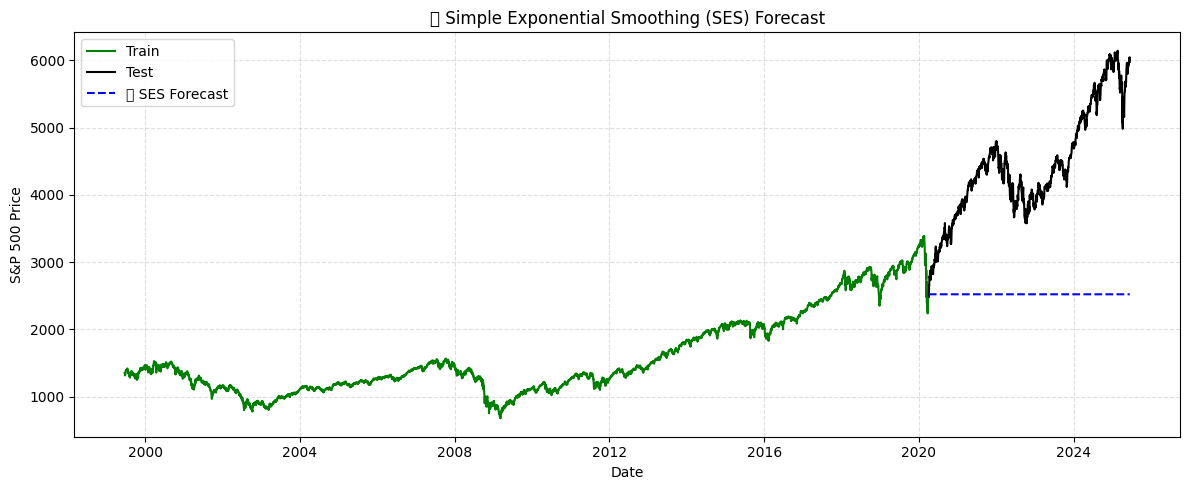


🔢 Last 5 SES Forecasted Values:
2025-06-09    2521.39
2025-06-10    2521.39
2025-06-11    2521.39
2025-06-12    2521.39
2025-06-13    2521.39
Freq: B


In [241]:
# ----------------------------------------
# Step 9.1: Simple Exponential Smoothing (SES)
# ----------------------------------------


# Fit on training raw data
ses_model = SimpleExpSmoothing(ts_train_raw).fit(optimized=True)

# Forecast for the length of the test set
forecast_ses = ses_model.forecast(len(ts_test_raw))

# Plot SES forecast
plt.figure(figsize=(12, 5))
plt.plot(ts_train_raw, label='Train', color='green')
plt.plot(ts_test_raw, label='Test', color='black')
plt.plot(forecast_ses, label='🔵 SES Forecast', linestyle='--', color='blue')
plt.title("📈 Simple Exponential Smoothing (SES) Forecast")
plt.xlabel("Date")
plt.ylabel("S&P 500 Price")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

# Text output
print("\n🔢 Last 5 SES Forecasted Values:")
print(forecast_ses.tail().round(2).to_string())


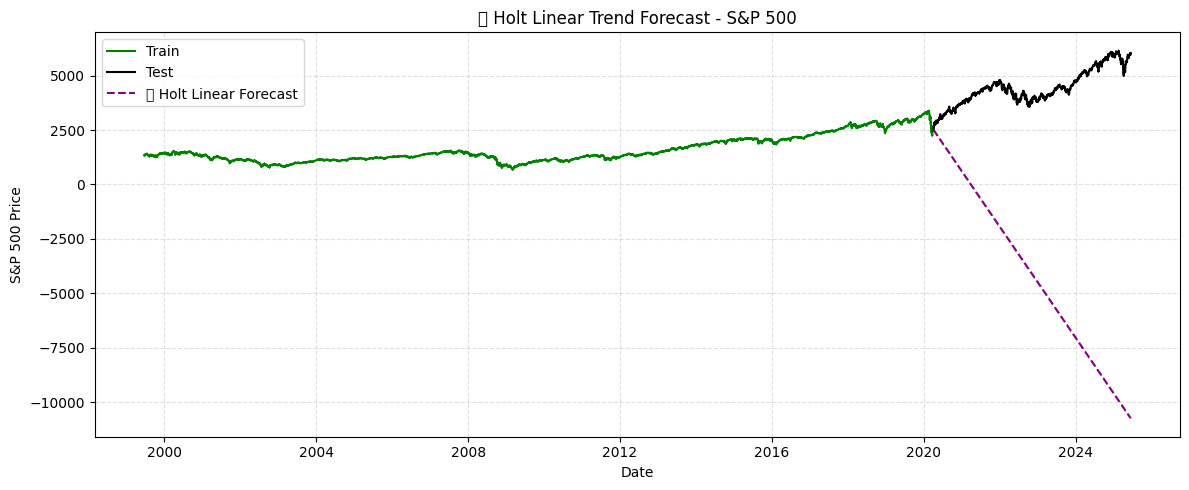


🔢 Last 5 Holt Forecasted Values:
2025-06-09   -10703.74
2025-06-10   -10713.52
2025-06-11   -10723.30
2025-06-12   -10733.08
2025-06-13   -10742.86
Freq: B


In [242]:
# ----------------------------------------
# Step 9.2: Holt’s Linear Trend Method
# ----------------------------------------


# Fit on training raw data
holt_model = Holt(ts_train_raw).fit(optimized=True)

# Forecast
forecast_holt = holt_model.forecast(len(ts_test_raw))

# Plot
plt.figure(figsize=(12, 5))
plt.plot(ts_train_raw, label='Train', color='green')
plt.plot(ts_test_raw, label='Test', color='black')
plt.plot(forecast_holt, label='🟣 Holt Linear Forecast', linestyle='--', color='purple')
plt.title("📈 Holt Linear Trend Forecast - S&P 500")
plt.xlabel("Date")
plt.ylabel("S&P 500 Price")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

# Textual Output
print("\n🔢 Last 5 Holt Forecasted Values:")
print(forecast_holt.tail().round(2).to_string())


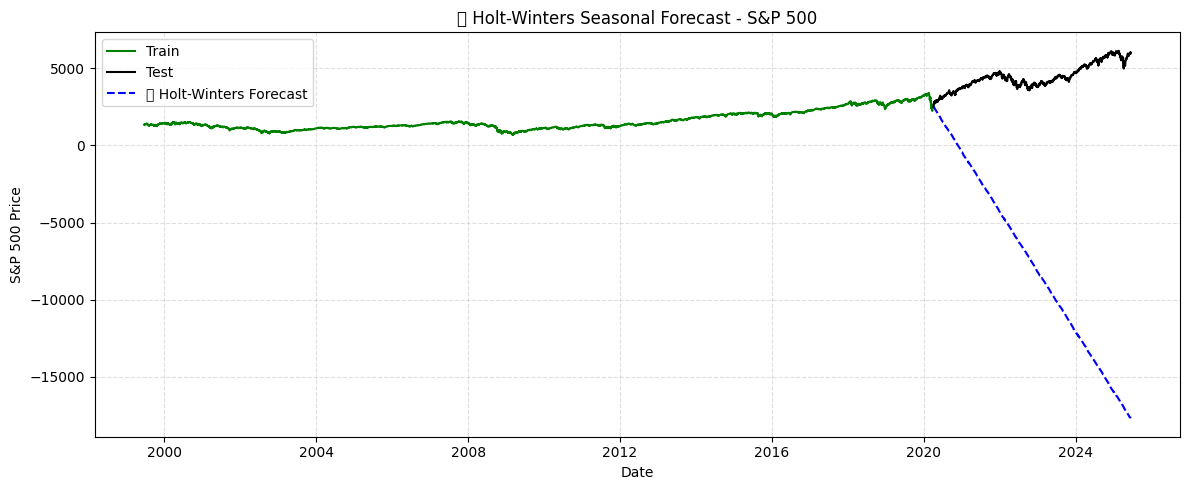


🔢 Last 5 Holt-Winters Forecasted Values:
2025-06-09   -17640.99
2025-06-10   -17661.93
2025-06-11   -17673.67
2025-06-12   -17683.20
2025-06-13   -17699.48
Freq: B


In [243]:
# ----------------------------------------
# Step 9.3: Holt-Winters Seasonal Method
# ----------------------------------------

# Approximate trading year seasonality
seasonal_period = 252

# Fit Holt-Winters model (additive seasonality, additive trend)
hw_model = ExponentialSmoothing(
    ts_train_raw,
    trend='add',
    seasonal='add',
    seasonal_periods=seasonal_period
).fit(optimized=True)

# Forecast
forecast_hw = hw_model.forecast(len(ts_test_raw))

# Plot
plt.figure(figsize=(12, 5))
plt.plot(ts_train_raw, label='Train', color='green')
plt.plot(ts_test_raw, label='Test', color='black')
plt.plot(forecast_hw, label='🔵 Holt-Winters Forecast', linestyle='--', color='blue')
plt.title("📈 Holt-Winters Seasonal Forecast - S&P 500")
plt.xlabel("Date")
plt.ylabel("S&P 500 Price")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

# Textual Output
print("\n🔢 Last 5 Holt-Winters Forecasted Values:")
print(forecast_hw.tail().round(2).to_string())


In [244]:
# ----------------------------------------
# 🔧 Fix: Create log-transformed train/test series
# ----------------------------------------
ts_log_train = np.log(ts_train_raw)
ts_log_test  = np.log(ts_test_raw)


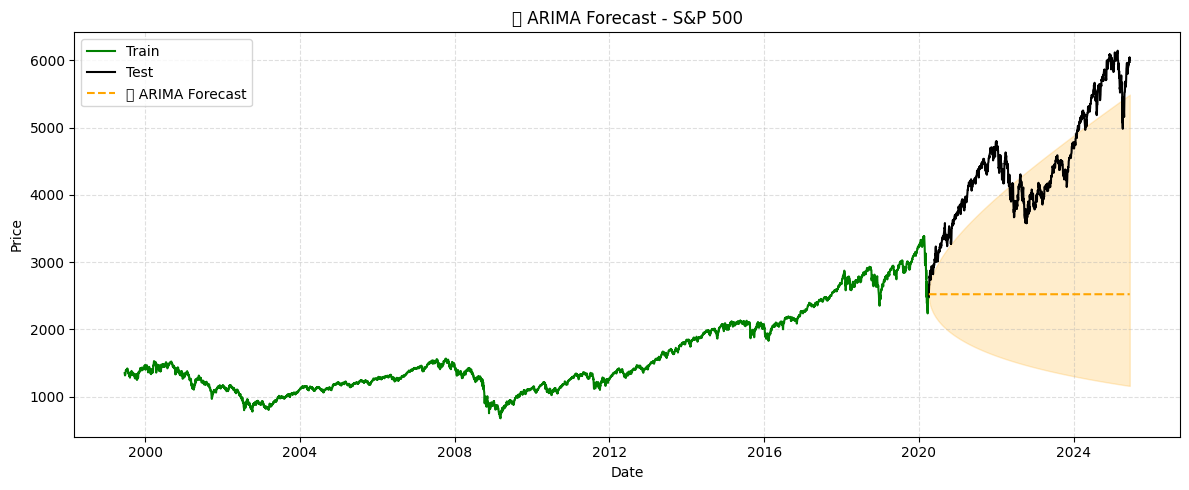


📋 ARIMA Forecast - Last 5 Days (Original Scale):
2025-06-09    2522.33
2025-06-10    2522.33
2025-06-11    2522.33
2025-06-12    2522.33
2025-06-13    2522.33
Freq: B


In [245]:
# ----------------------------------------
# Step 10: ARIMA Model (Stationary Branch)
# ----------------------------------------

# Define ARIMA order (can be tuned using ACF/PACF)
p, d, q = 1, 1, 1

# Fit ARIMA model on log-transformed training series
arima_model = ARIMA(ts_log_train, order=(p, d, q))
arima_result = arima_model.fit()

# Forecast in log scale
forecast_log = arima_result.get_forecast(steps=len(ts_test_raw))
forecast_ci = forecast_log.conf_int()

# Revert to original scale (exp)
forecast_arima = np.exp(forecast_log.predicted_mean)
conf_int_arima = np.exp(forecast_ci)

# Plot
plt.figure(figsize=(12, 5))
plt.plot(ts_train_raw, label='Train', color='green')
plt.plot(ts_test_raw, label='Test', color='black')
plt.plot(forecast_arima, label='🔵 ARIMA Forecast', linestyle='--', color='orange')
plt.fill_between(forecast_arima.index, conf_int_arima.iloc[:, 0], conf_int_arima.iloc[:, 1], color='orange', alpha=0.2)
plt.title("🔮 ARIMA Forecast - S&P 500")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

# ⌨️ Text Output
print("\n📋 ARIMA Forecast - Last 5 Days (Original Scale):")
print(forecast_arima.tail().round(2).to_string())


2025-06-14 18:38:30,869 - DEBUG - cmd: where.exe tbb.dll
cwd: None
2025-06-14 18:38:31,022 - DEBUG - TBB already found in load path
2025-06-14 18:38:31,117 - DEBUG - input tempfile: C:\Users\Asus\AppData\Local\Temp\tmpj85tq0_2\nof2iu4p.json
2025-06-14 18:38:31,820 - DEBUG - input tempfile: C:\Users\Asus\AppData\Local\Temp\tmpj85tq0_2\cv6_uga7.json
2025-06-14 18:38:31,831 - DEBUG - idx 0
2025-06-14 18:38:31,832 - DEBUG - running CmdStan, num_threads: None
2025-06-14 18:38:31,833 - DEBUG - CmdStan args: ['D:\\New Programming Projects (Pycharm, VS Code, e.t.c.)\\FoEM\\FoEM\\venv\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=2155', 'data', 'file=C:\\Users\\Asus\\AppData\\Local\\Temp\\tmpj85tq0_2\\nof2iu4p.json', 'init=C:\\Users\\Asus\\AppData\\Local\\Temp\\tmpj85tq0_2\\cv6_uga7.json', 'output', 'file=C:\\Users\\Asus\\AppData\\Local\\Temp\\tmpj85tq0_2\\prophet_model_ot25ia7\\prophet_model-20250614183831.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000'

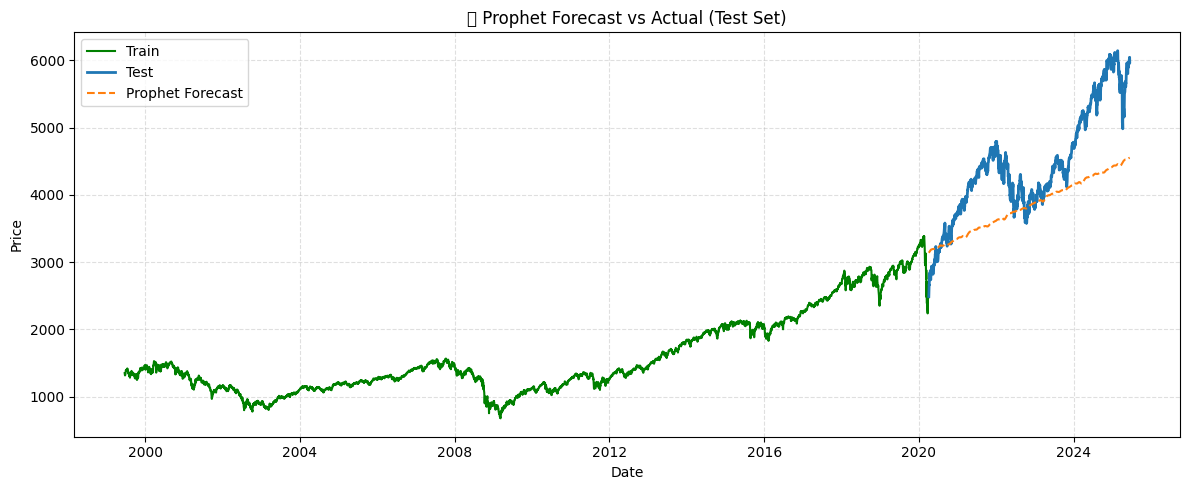


🔢 Prophet Forecast Sample:
Date
2020-04-03    3139.034254
2020-04-06    3146.399415
2020-04-07    3149.787707
2020-04-08    3152.624202
2020-04-09    3155.585527
Freq: B, dtype: float64


In [246]:
# ----------------------------------------
# Step 11: Prophet Forecast (Raw Series)
# ----------------------------------------


# ✅ Prepare data for Prophet (requires specific column names)
df_prophet = ts_train_raw.reset_index()
df_prophet.columns = ['ds', 'y']

# ⚙️ Fit Prophet model
prophet_model = Prophet(daily_seasonality=True)
prophet_model.fit(df_prophet)

# 📅 Create future dataframe matching length of test set
future = prophet_model.make_future_dataframe(periods=len(ts_test_raw), freq='B')

# 🔮 Make forecast
forecast_prophet = prophet_model.predict(future)

# 🔁 Extract only the forecasted part for comparison
forecast_prophet_test = forecast_prophet[['ds', 'yhat']].set_index('ds').loc[ts_test_raw.index]
forecast_prophet_series = pd.Series(forecast_prophet_test['yhat'].values, index=ts_test_raw.index)

# 📊 Plot forecast vs actual
plt.figure(figsize=(12, 5))
plt.plot(ts_train_raw, label='Train', color='green')
plt.plot(ts_test_raw, label="Test", linewidth=2)
plt.plot(forecast_prophet_series, label="Prophet Forecast", linestyle="--")
plt.title("📈 Prophet Forecast vs Actual (Test Set)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

# 🧾 Output sample
print("\n🔢 Prophet Forecast Sample:")
print(forecast_prophet_series.head())


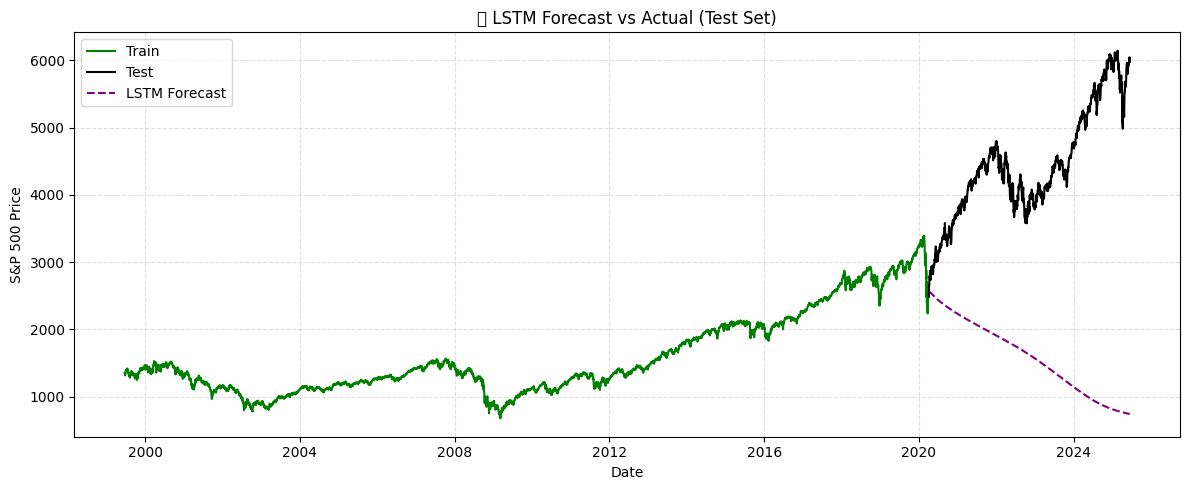


🔢 LSTM Forecast Sample:
Date
2020-04-03    2551.944824
2020-04-06    2554.077637
2020-04-07    2555.537109
2020-04-08    2556.105957
2020-04-09    2555.983643
Freq: B, dtype: float32


In [247]:
# ----------------------------------------
# Step 12: LSTM Forecast (Raw Series)
# ----------------------------------------


# Parameters
window_size = 30
n_features = 1

# Scale training data
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(ts_train_raw.values.reshape(-1, 1))

# Prepare supervised sequences
X_lstm, y_lstm = [], []
for i in range(window_size, len(scaled_train)):
    X_lstm.append(scaled_train[i - window_size:i])
    y_lstm.append(scaled_train[i])

X_lstm, y_lstm = np.array(X_lstm), np.array(y_lstm)

# Build LSTM model
lstm_model = Sequential([
    LSTM(50, activation='relu', input_shape=(window_size, n_features)),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X_lstm, y_lstm, epochs=20, batch_size=32, verbose=0)

# Forecast next len(test) steps
lstm_input = scaled_train[-window_size:].reshape(1, window_size, n_features)
forecast_lstm = []
for _ in range(len(ts_test_raw)):
    pred = lstm_model.predict(lstm_input, verbose=0)
    forecast_lstm.append(pred[0, 0])
    lstm_input = np.append(lstm_input[:, 1:, :], [[[pred[0, 0]]]], axis=1)

# Reverse scaling
forecast_lstm = scaler.inverse_transform(np.array(forecast_lstm).reshape(-1, 1)).flatten()
lstm_forecast_series = pd.Series(forecast_lstm, index=ts_test_raw.index)

# Plot
plt.figure(figsize=(12, 5))
plt.plot(ts_train_raw, label="Train", color='green')
plt.plot(ts_test_raw, label="Test", color='black')
plt.plot(lstm_forecast_series, label="LSTM Forecast", linestyle='--', color='purple')
plt.title("🧠 LSTM Forecast vs Actual (Test Set)")
plt.xlabel("Date")
plt.ylabel("S&P 500 Price")
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

# Sample output
print("\n🔢 LSTM Forecast Sample:")
print(lstm_forecast_series.head())


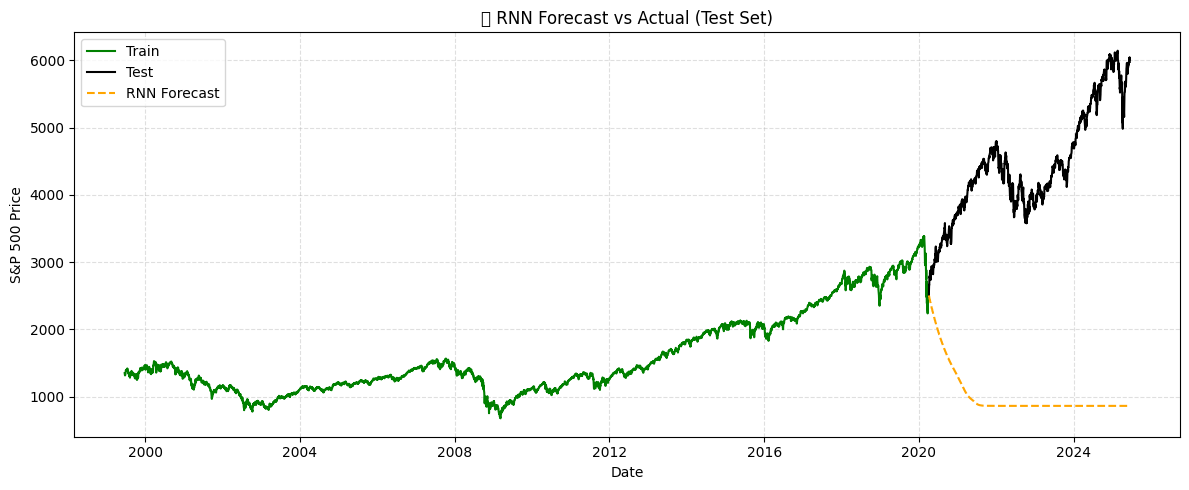


🔢 RNN Forecast Sample:
Date
2020-04-03    2485.139893
2020-04-06    2492.939941
2020-04-07    2481.896729
2020-04-08    2476.053467
2020-04-09    2463.586670
Freq: B, dtype: float32


In [248]:
# ----------------------------------------
# Step 13: RNN Forecast (Raw Series)
# ----------------------------------------


# Build RNN model
rnn_model = Sequential([
    SimpleRNN(50, activation='relu', input_shape=(window_size, n_features)),
    Dense(1)
])
rnn_model.compile(optimizer='adam', loss='mse')
rnn_model.fit(X_lstm, y_lstm, epochs=20, batch_size=32, verbose=0)

# Forecast next len(test) steps
rnn_input = scaled_train[-window_size:].reshape(1, window_size, n_features)
forecast_rnn = []
for _ in range(len(ts_test_raw)):
    pred = rnn_model.predict(rnn_input, verbose=0)
    forecast_rnn.append(pred[0, 0])
    rnn_input = np.append(rnn_input[:, 1:, :], [[[pred[0, 0]]]], axis=1)

# Reverse scaling
forecast_rnn = scaler.inverse_transform(np.array(forecast_rnn).reshape(-1, 1)).flatten()
rnn_forecast_series = pd.Series(forecast_rnn, index=ts_test_raw.index)

# Plot
plt.figure(figsize=(12, 5))
plt.plot(ts_train_raw, label="Train", color='green')
plt.plot(ts_test_raw, label="Test", color='black')
plt.plot(rnn_forecast_series, label="RNN Forecast", linestyle='--', color='orange')
plt.title("🔁 RNN Forecast vs Actual (Test Set)")
plt.xlabel("Date")
plt.ylabel("S&P 500 Price")
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

# Sample output
print("\n🔢 RNN Forecast Sample:")
print(rnn_forecast_series.head())


In [249]:
# ----------------------------------------
# Step 14: Evaluation - MAE, RMSE, MAPE
# ----------------------------------------


# 🧪 Helper to compute metrics
eval_results = {}

def evaluate_model(true, pred, label):
    mae = mean_absolute_error(true, pred)
    rmse = np.sqrt(mean_squared_error(true, pred))
    mape = np.mean(np.abs((true - pred) / true)) * 100
    eval_results[label] = {'MAE': mae, 'RMSE': rmse, 'MAPE': mape}

# 🎯 Run evaluations
evaluate_model(ts_test_raw, naive_forecast, "Naive")
evaluate_model(ts_test_raw, seasonal_naive_forecast, "Seasonal Naive")
evaluate_model(ts_test_raw, drift_forecast, "Drift")
evaluate_model(ts_test_raw, mean_forecast, "Mean")

evaluate_model(ts_test_raw, forecast_ses, "SES")
evaluate_model(ts_test_raw, forecast_holt, "Holt Linear")
evaluate_model(ts_test_raw, forecast_hw, "Holt-Winters")

evaluate_model(ts_test_raw, forecast_arima, "ARIMA")
evaluate_model(ts_test_raw, forecast_prophet_series, "Prophet")
evaluate_model(ts_test_raw, forecast_lstm, "LSTM")
evaluate_model(ts_test_raw, forecast_rnn, "RNN")

# 📊 Convert to DataFrame
eval_df = pd.DataFrame(eval_results).T.round(2)
eval_df = eval_df.sort_values(by="RMSE")  # Sort by RMSE

# 📋 Show table
print("📈 Model Evaluation Metrics (on Test Set):")
display(eval_df)


📈 Model Evaluation Metrics (on Test Set):


,MAE,RMSE,MAPE
Prophet,640.61,794.06,13.23
Seasonal Naive,1463.60,1682.20,30.64
Drift,1779.14,1926.93,38.21
Naive,1926.51,2090.76,41.32
ARIMA,1931.08,2094.97,41.43
SES,1932.01,2095.83,41.45
Mean,2866.07,2978.99,63.14
LSTM,2865.64,3151.44,61.13
RNN,3437.56,3600.82,75.22
Holt Linear,8570.07,9702.41,181.60


📌 Lower RMSE and MAE values indicate better performance.  
MAPE (%) gives a relative error percentage — useful for comparing across models.  
The best models are typically those with lowest RMSE and reasonable MAPE.

### Step 15: Comparing models

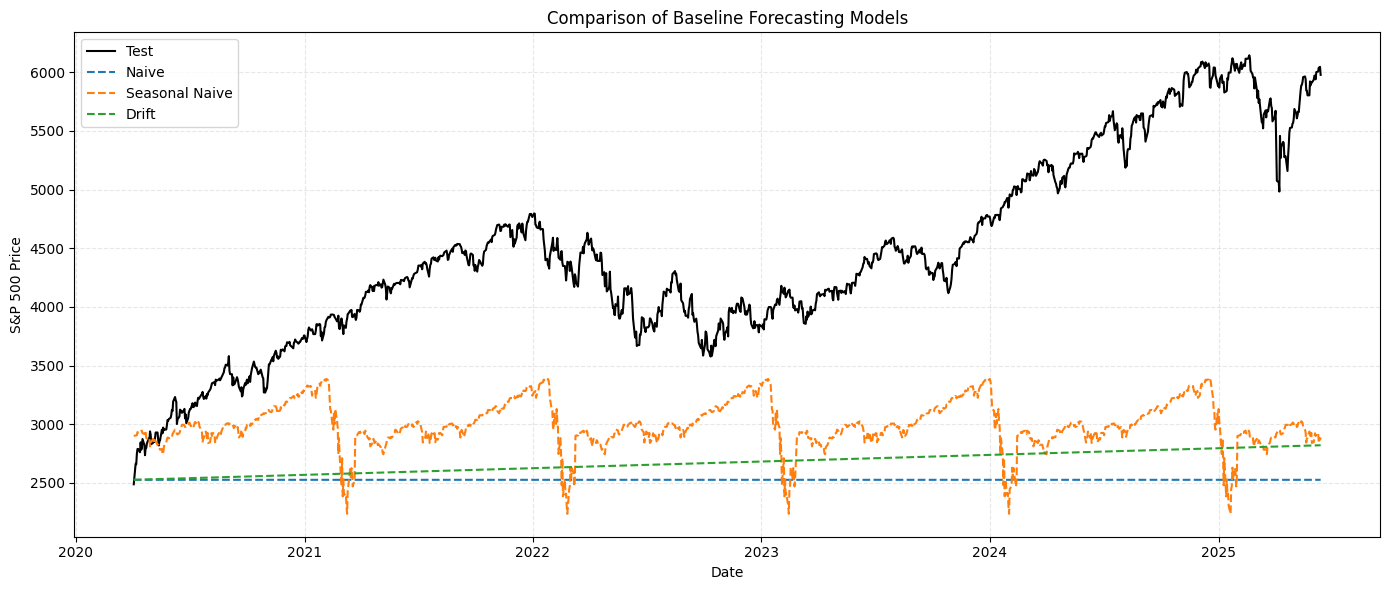

In [250]:
plt.figure(figsize=(14, 6))
plt.plot(ts_test_raw, label="Test", color="black")
plt.plot(naive_forecast, label="Naive", linestyle='--')
plt.plot(seasonal_naive_forecast, label="Seasonal Naive", linestyle='--')
plt.plot(drift_forecast, label="Drift", linestyle='--')
plt.title("Comparison of Baseline Forecasting Models")
plt.xlabel("Date")
plt.ylabel("S&P 500 Price")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

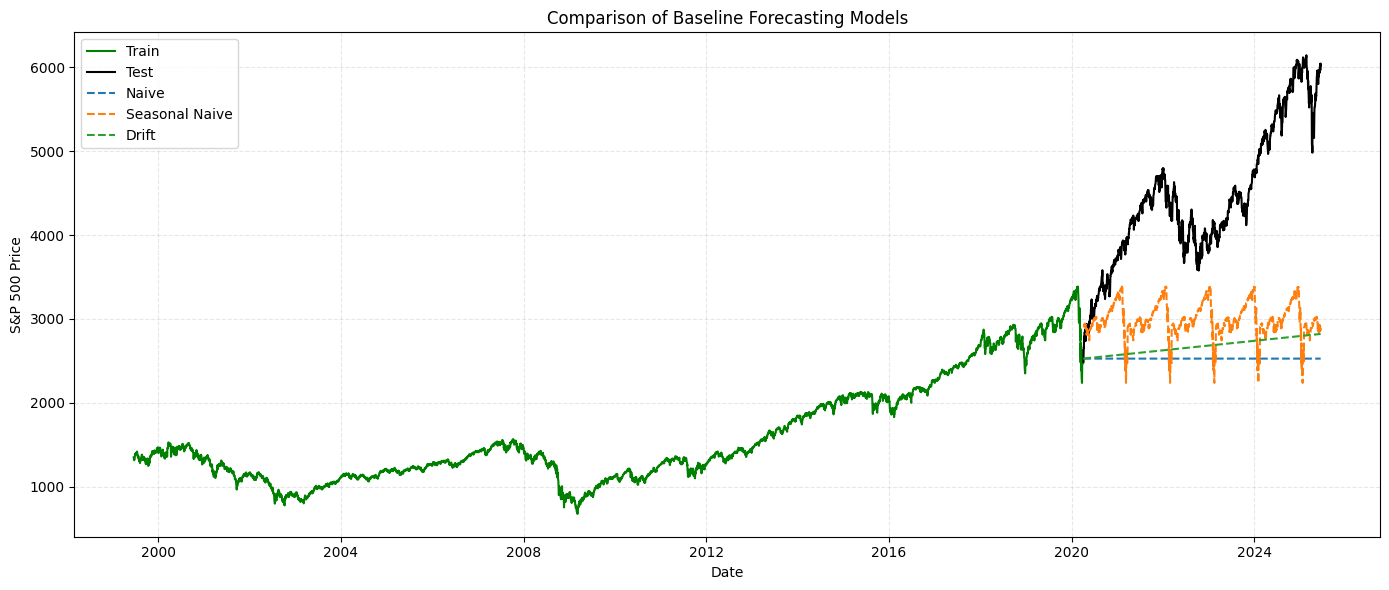

In [251]:
plt.figure(figsize=(14, 6))
plt.plot(ts_train_raw, label="Train", color="green")
plt.plot(ts_test_raw, label="Test", color="black")
plt.plot(naive_forecast, label="Naive", linestyle='--')
plt.plot(seasonal_naive_forecast, label="Seasonal Naive", linestyle='--')
plt.plot(drift_forecast, label="Drift", linestyle='--')
plt.title("Comparison of Baseline Forecasting Models")
plt.xlabel("Date")
plt.ylabel("S&P 500 Price")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

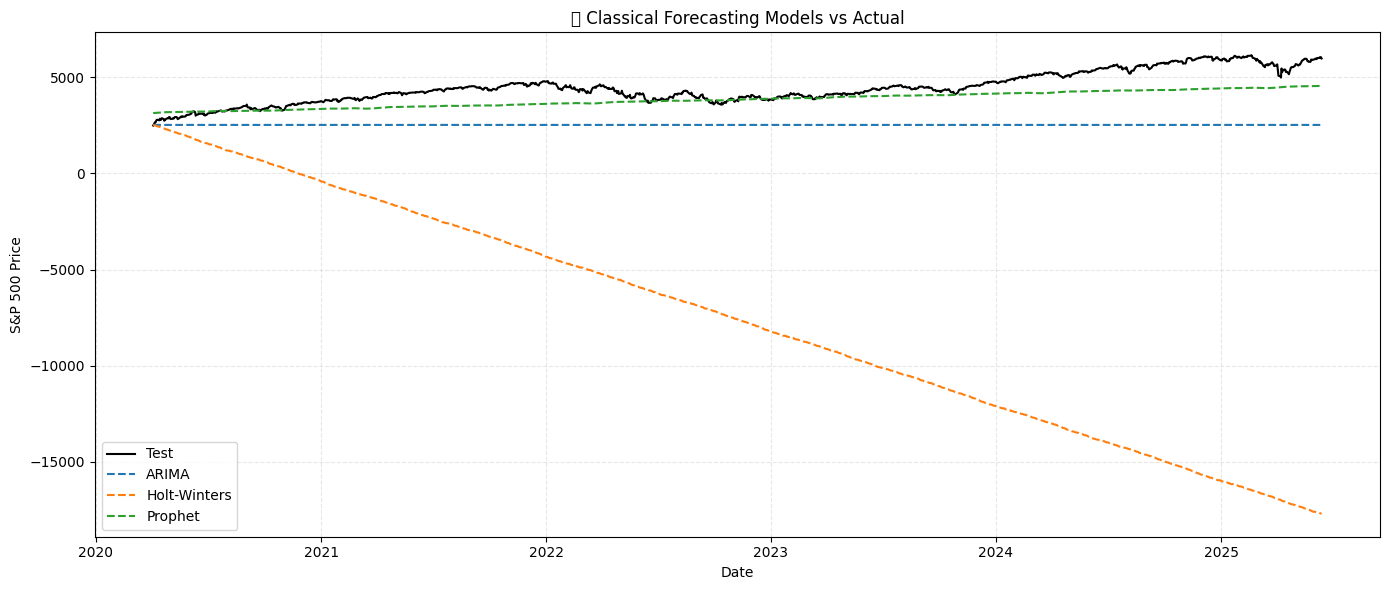

In [252]:
plt.figure(figsize=(14, 6))
plt.plot(ts_test_raw, label="Test", color="black")
plt.plot(forecast_arima, label="ARIMA", linestyle='--')
plt.plot(forecast_hw, label="Holt-Winters", linestyle='--')
plt.plot(forecast_prophet_series, label="Prophet", linestyle='--')
plt.title("📊 Classical Forecasting Models vs Actual")
plt.xlabel("Date")
plt.ylabel("S&P 500 Price")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

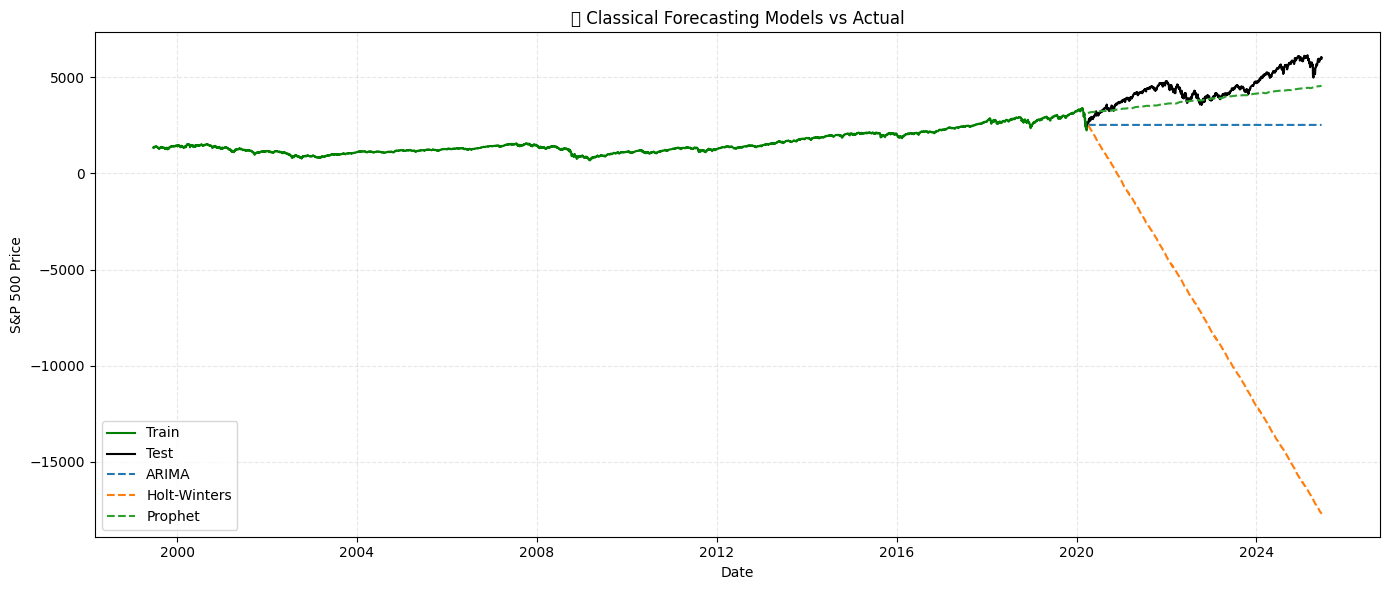

In [253]:
plt.figure(figsize=(14, 6))
plt.plot(ts_train_raw, label="Train", color="green")
plt.plot(ts_test_raw, label="Test", color="black")
plt.plot(forecast_arima, label="ARIMA", linestyle='--')
plt.plot(forecast_hw, label="Holt-Winters", linestyle='--')
plt.plot(forecast_prophet_series, label="Prophet", linestyle='--')
plt.title("📊 Classical Forecasting Models vs Actual")
plt.xlabel("Date")
plt.ylabel("S&P 500 Price")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

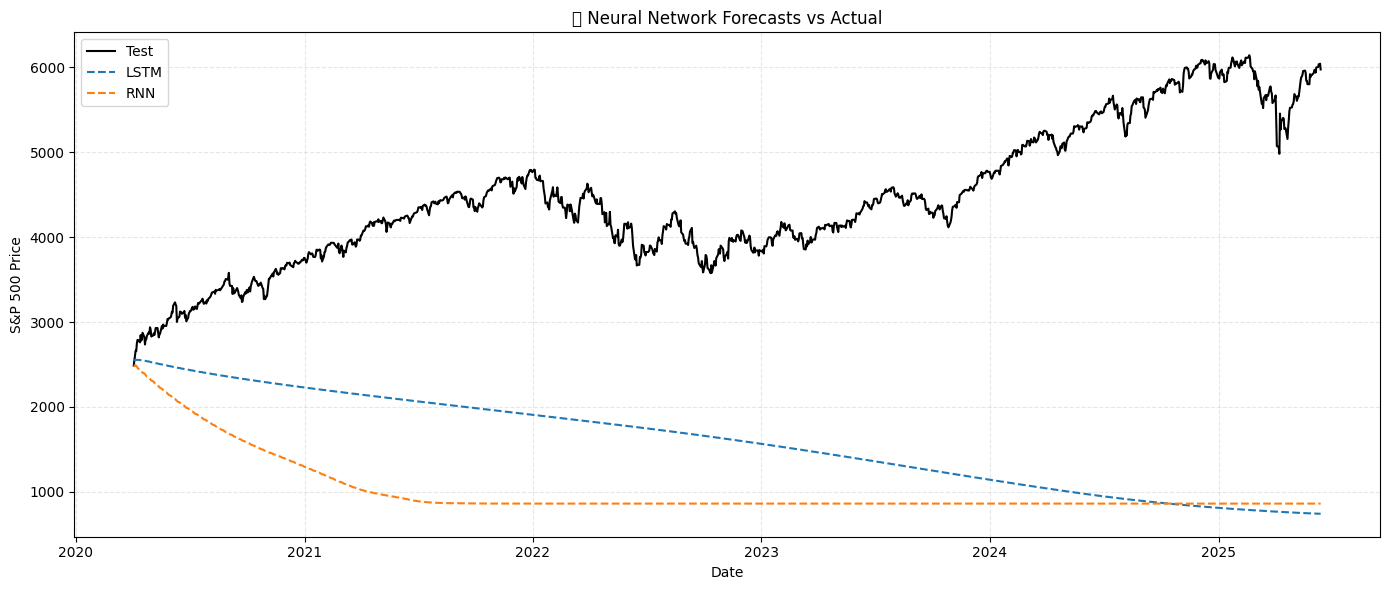

In [254]:
plt.figure(figsize=(14, 6))
plt.plot(ts_test_raw, label="Test", color="black")
plt.plot(lstm_forecast_series, label="LSTM", linestyle='--')
plt.plot(rnn_forecast_series, label="RNN", linestyle='--')
plt.title("🧠 Neural Network Forecasts vs Actual")
plt.xlabel("Date")
plt.ylabel("S&P 500 Price")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

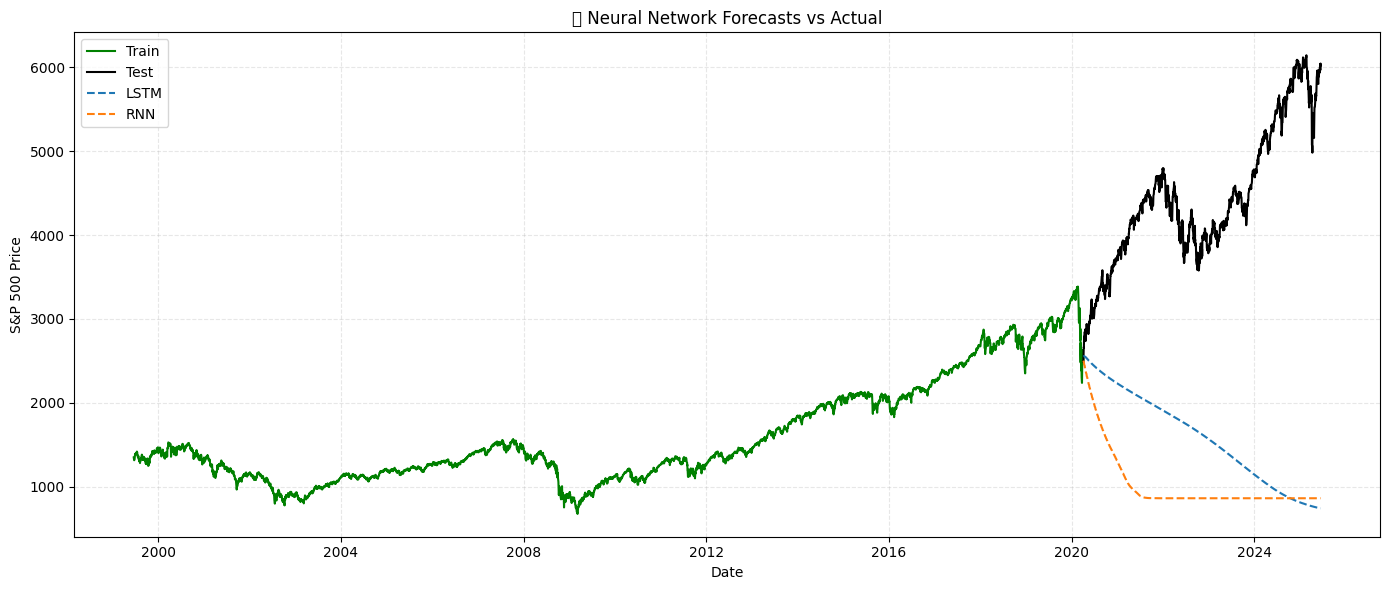

In [255]:
plt.figure(figsize=(14, 6))
plt.plot(ts_train_raw, label="Train", color="green")
plt.plot(ts_test_raw, label="Test", color="black")
plt.plot(lstm_forecast_series, label="LSTM", linestyle='--')
plt.plot(rnn_forecast_series, label="RNN", linestyle='--')
plt.title("🧠 Neural Network Forecasts vs Actual")
plt.xlabel("Date")
plt.ylabel("S&P 500 Price")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

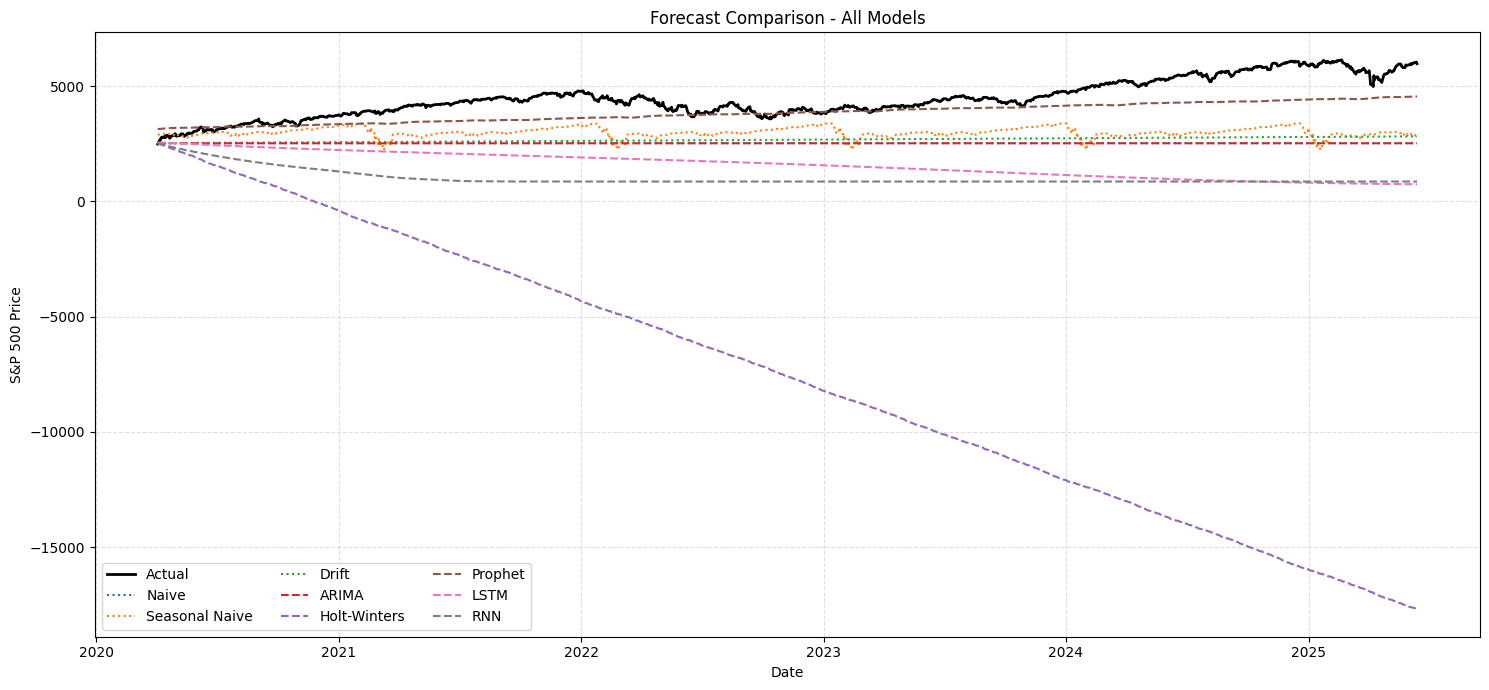

In [256]:
plt.figure(figsize=(15, 7))

plt.plot(ts_test_raw, label="Actual", color="black", linewidth=2)
plt.plot(naive_forecast, label="Naive", linestyle=':')
plt.plot(seasonal_naive_forecast, label="Seasonal Naive", linestyle=':')
plt.plot(drift_forecast, label="Drift", linestyle=':')
plt.plot(forecast_arima, label="ARIMA", linestyle='--')
plt.plot(forecast_hw, label="Holt-Winters", linestyle='--')
plt.plot(forecast_prophet_series, label="Prophet", linestyle='--')
plt.plot(lstm_forecast_series, label="LSTM", linestyle='--')
plt.plot(rnn_forecast_series, label="RNN", linestyle='--')
plt.title("Forecast Comparison - All Models")
plt.xlabel("Date")
plt.ylabel("S&P 500 Price")
plt.legend(ncol=3)
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

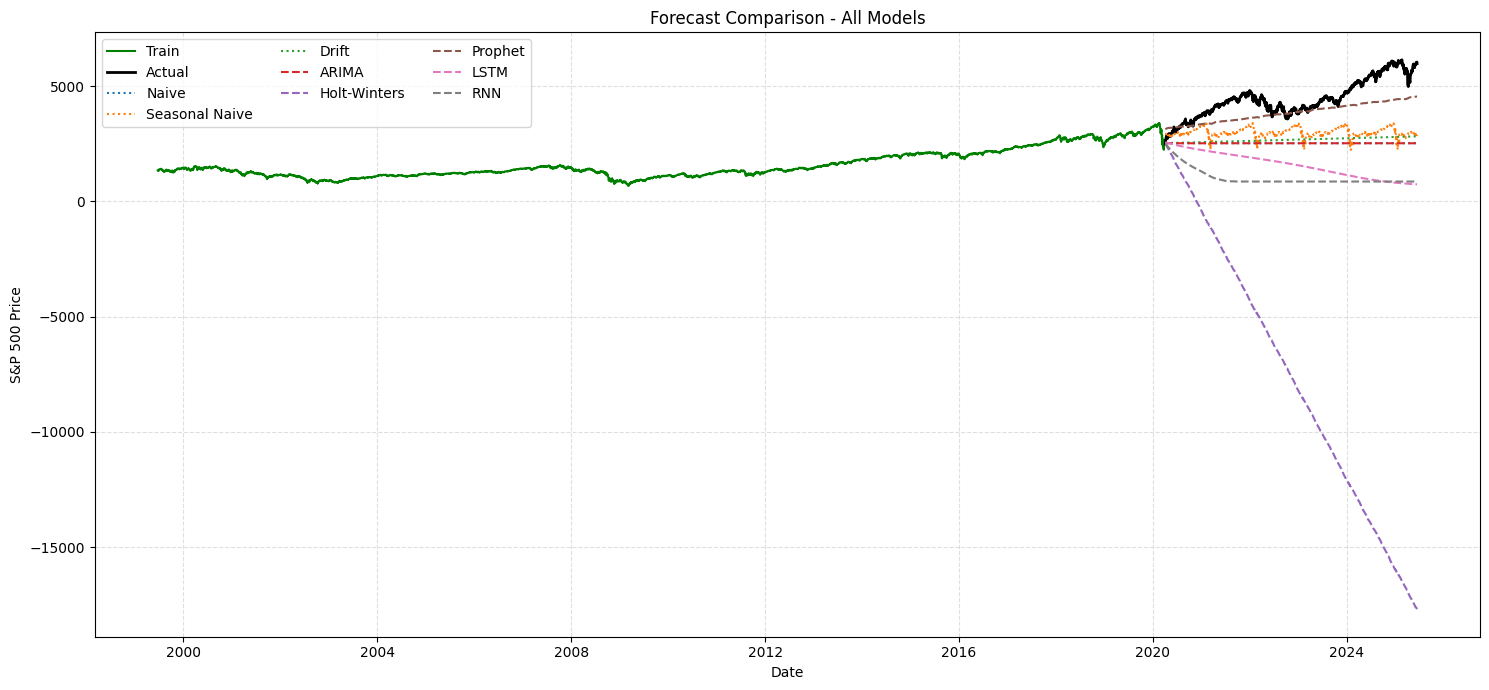

In [257]:
plt.figure(figsize=(15, 7))
plt.plot(ts_train_raw, label="Train", color="green")
plt.plot(ts_test_raw, label="Actual", color="black", linewidth=2)
plt.plot(naive_forecast, label="Naive", linestyle=':')
plt.plot(seasonal_naive_forecast, label="Seasonal Naive", linestyle=':')
plt.plot(drift_forecast, label="Drift", linestyle=':')
plt.plot(forecast_arima, label="ARIMA", linestyle='--')
plt.plot(forecast_hw, label="Holt-Winters", linestyle='--')
plt.plot(forecast_prophet_series, label="Prophet", linestyle='--')
plt.plot(lstm_forecast_series, label="LSTM", linestyle='--')
plt.plot(rnn_forecast_series, label="RNN", linestyle='--')
plt.title("Forecast Comparison - All Models")
plt.xlabel("Date")
plt.ylabel("S&P 500 Price")
plt.legend(ncol=3)
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()